In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp
import matplotlib as mpl

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.accstudies.met.lepveto

In [3]:
# signal = ObjIter([ Tree(list(filter(lambda f,mx=mx : f'MX_{mx}' in f, module.full_signal_list))) for mx in mx_list ])
import functools
import multiprocessing as mp

open_tree = functools.partial(Tree, report=False)

with mp.pool.ThreadPool(8) as pool:
    signal = ObjIter(module.extended_signal_list).pool_apply(open_tree, report=True, pool=pool)


partial: 100%|██████████| 46/46 [07:28<00:00,  9.76s/it]


In [4]:
for s in signal:
    s.total_events = 0
    for f in s.filelist:
        if 'h_cutflow_unweighted' not in f.histograms:
            f.load_histograms(['h_cutflow_unweighted'])
        s.total_events += f.histograms['h_cutflow_unweighted'].counts()[0]

In [5]:
def nfound_maxbtag(t):
    btag = t.jet_btag 
    jid = t.jet_signalId

    jid = jid[ak_rank(-btag, axis=1) < 8]

    t.extend(nfound_select=ak.sum(jid>-1, axis=1))

In [6]:
signal.apply(nfound_maxbtag,report=True)

nfound_maxbtag:  63%|██████▎   | 29/46 [04:40<03:27, 12.21s/it]

KeyboardInterrupt: 

In [ ]:
trigger = "HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5"
def preselection(t):
    mask = t[trigger] & (t.n_jet >= 8)
    return ak.sum(mask)

def gen_matched_preselection(t, n=8):
    jid = t.jet_signalId
    n_genb = ak.sum(jid>-1, axis=-1)

    mask = t[trigger] & (n_genb >= n)
    return ak.sum(mask)

def gen_matched_all(t, n=8):
    n_genb = t.nfound_all

    mask = t[trigger] & (n_genb >= n)
    return ak.sum(mask)


def n_gen_matched_preselection(t):
    jid = t.jet_signalId

    n_genb = ak.sum(jid>-1, axis=-1)
    mask = t[trigger]
    return ak.mean( n_genb[mask] )

In [ ]:
def reco_eff(t):
    mask = (t[trigger] == 1) & (t.n_jet >= 8)
    nfound = t.nfound_select[mask]
    # return 100*ak.mean(nfound==8)
    return ak.mean(nfound)

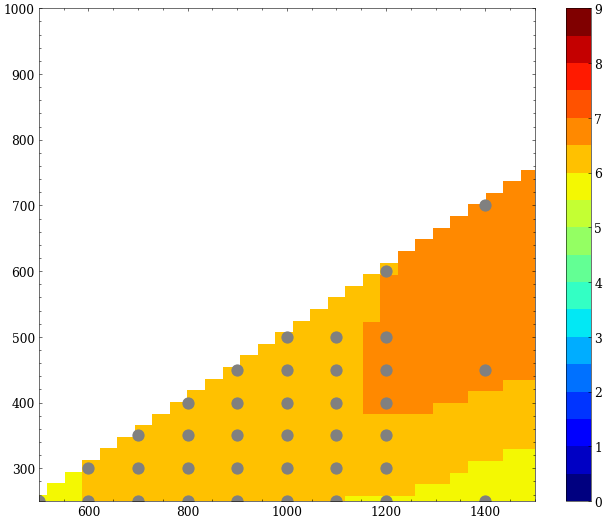

In [ ]:
study.mxmy_phase(
    signal,
    f_var=reco_eff,
    xlim=(500,1500),
    ylim=(250,1000),
    # zlim=np.linspace(0,20,9),
    zlim=np.linspace(0,9,19),
    g_cmap='jet',
)

In [42]:
def gen_quark_dr(t):
    genb_eta = ak_stack([ t[f'gen_{quark}_eta'] for quark in eightb.quarklist], axis=1)
    genb_phi = ak_stack([ t[f'gen_{quark}_phi'] for quark in eightb.quarklist], axis=1)

    genb1_eta, genb2_eta = ak.unzip(ak.combinations(genb_eta, n=2, axis=1))
    genb1_phi, genb2_phi = ak.unzip(ak.combinations(genb_phi, n=2, axis=1))

    gen_bb_dr = calc_dr(genb1_eta, genb1_phi, genb2_eta, genb2_phi)

    t.extend(
        min_gen_bb_dr = ak.min(gen_bb_dr, axis=1),
        max_gen_bb_dr = ak.max(gen_bb_dr, axis=1),
        n_gen_bb_dr0p4 = ak.sum( gen_bb_dr < 0.4, axis=1 ),
        n_gen_bb_dr0p8 = ak.sum( gen_bb_dr < 0.8, axis=1 ),
    )

signal.apply(gen_quark_dr, report=True)


100%|██████████| 21/21 [02:20<00:00,  6.68s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [43]:
selected = np.arange(21)[::5].tolist()

In [44]:
varinfo.min_gen_bb_dr = dict(bins=(0,1.0,30))
varinfo.max_gen_bb_dr = dict(bins=(3.0,6,30))

100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


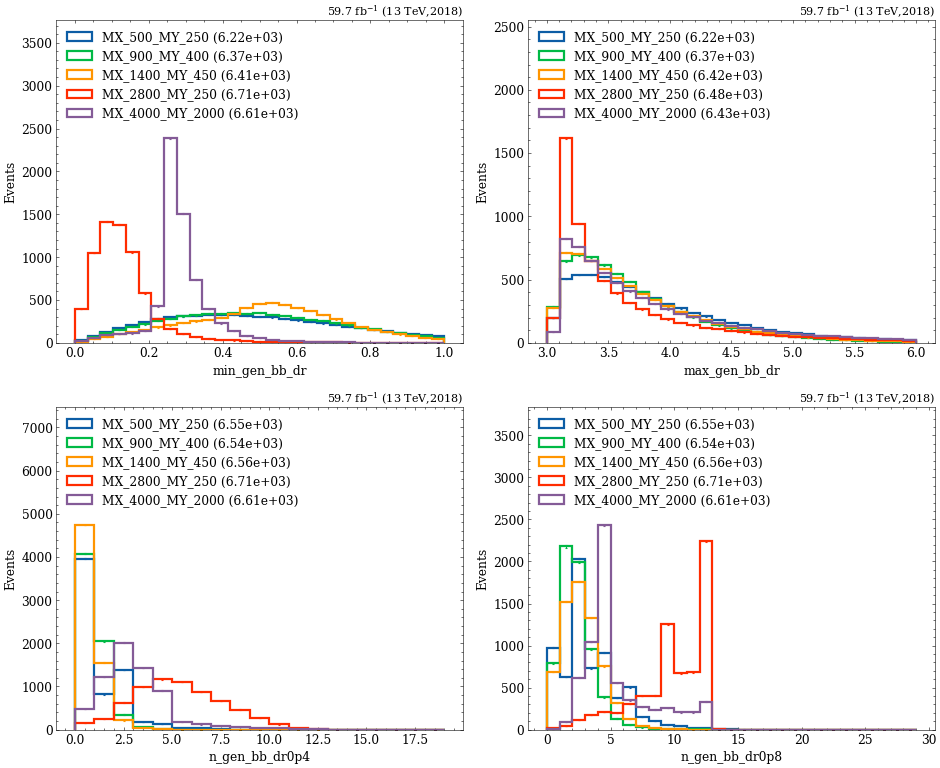

In [45]:
study.quick(
    signal[selected],
    legend=True,
    varlist=['min_gen_bb_dr','max_gen_bb_dr','n_gen_bb_dr0p4','n_gen_bb_dr0p8'],
)

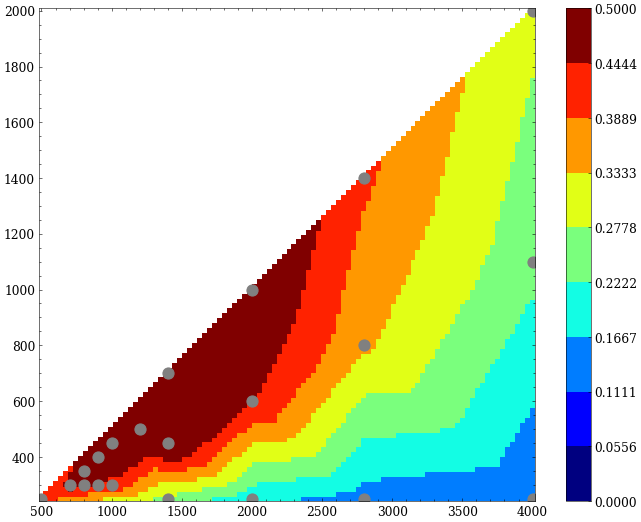

In [145]:
def f_var(t):
    mask = (t[trigger] == 1) & (t.n_jet >= 8)
    v = t.min_gen_bb_dr[mask]

    return ak_quantile(v, quantile=0.5)

study.mxmy_phase(
    signal,
    f_var=f_var,
    # xlim=(500,1500),
    # ylim=(250,1000),
    # zlim=np.linspace(0,20,9),
    zlim=np.linspace(0,0.5,10),
    g_cmap='jet',
)

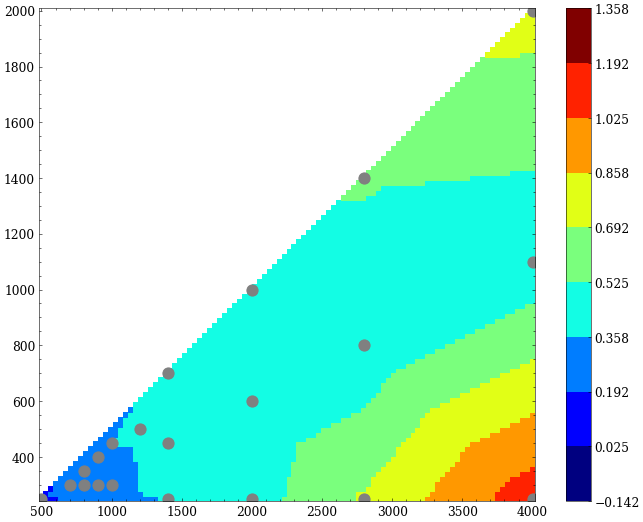

In [146]:
def f_var(t):
    mask = (t[trigger] == 1) & (t.n_jet >= 8)
    v = t.max_gen_bb_dr[mask]

    return ak_quantile(v, quantile=0.5)-np.pi

study.mxmy_phase(
    signal,
    f_var=f_var,
    # xlim=(500,1500),
    # ylim=(250,1000),
    # zlim=np.linspace(0,20,9),
    zlim=np.linspace(3,4.5,10)-np.pi,
    g_cmap='jet',
)

100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


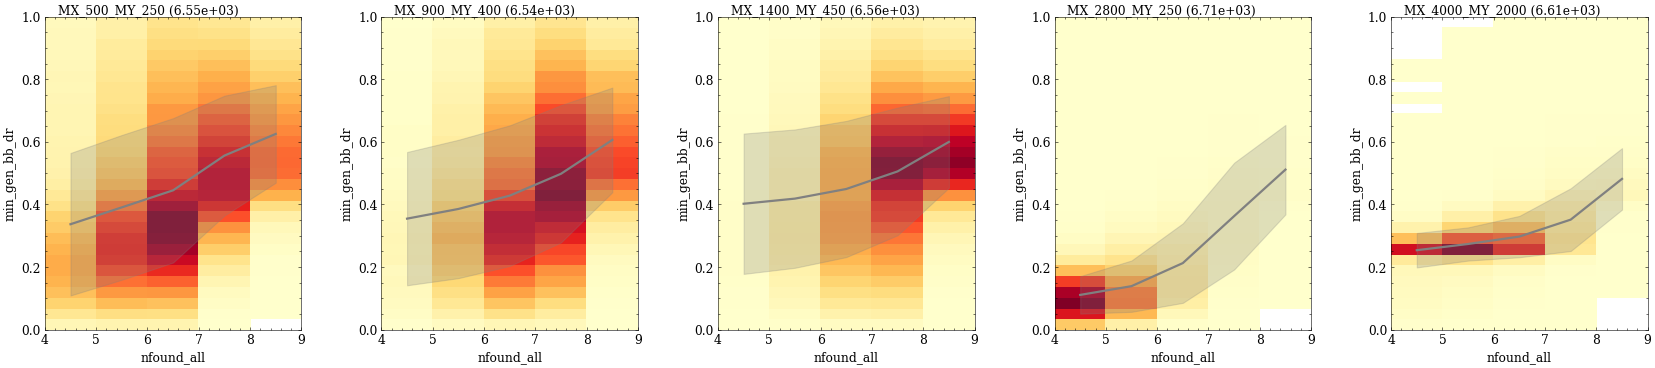

In [234]:
study.quick2d(
    signal[selected],
    legend=True,
    varlist=['nfound_all','min_gen_bb_dr'],
    binlist=[np.arange(4,10)],
    exe=plot_histo2d_x_corr,
)

In [251]:
def mxmy_phase(signal, f_var, figax=None, interp=True, colorbar=True, xlim=None, ylim=None, xlabel=None, ylabel=None, **kwargs):
    if figax is None: figax = study.get_figax(size=(10,8))

    mx = signal.mx.npy 
    my = signal.my.npy 

    var = f_var
    if callable(f_var):
        var = signal.apply(f_var).npy
    

    graph2d_array(mx, my, var, figax=figax, interp=interp, colorbar=True, **kwargs)
    graph_array(mx, my, figax=figax, g_color='grey', g_ls='none', g_markersize=10, xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel)

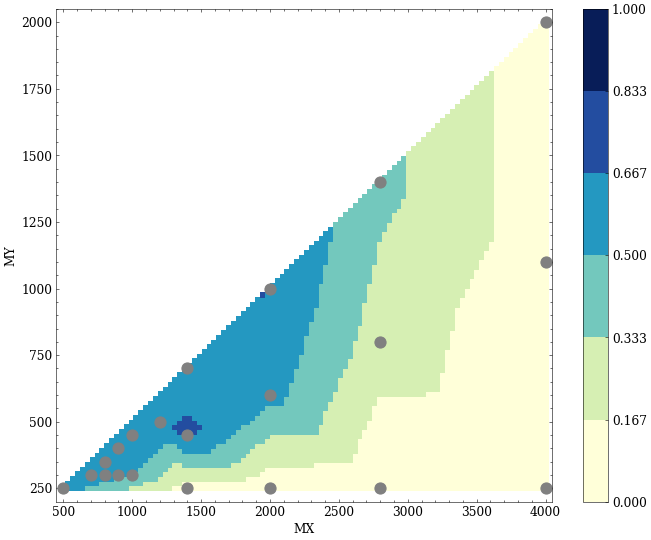

In [254]:
mxmy_phase(
    signal,
    lambda t : np.sum(t.min_gen_bb_dr > 0.4)/t.total_events,
    g_cmap='YlGnBu',    
    xlabel='MX',
    ylabel='MY',
    xlim=(450,4050),
    ylim=(200,2050),
    zlim=np.linspace(0,1,7),
)

In [7]:
presel_eff = signal.apply(lambda t : preselection(t)/t.total_events, report=True).npy

100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


(<Figure size 800x640 with 2 Axes>,
 <AxesSubplot:title={'center':'Preselection'}, xlabel='MX', ylabel='MY'>)

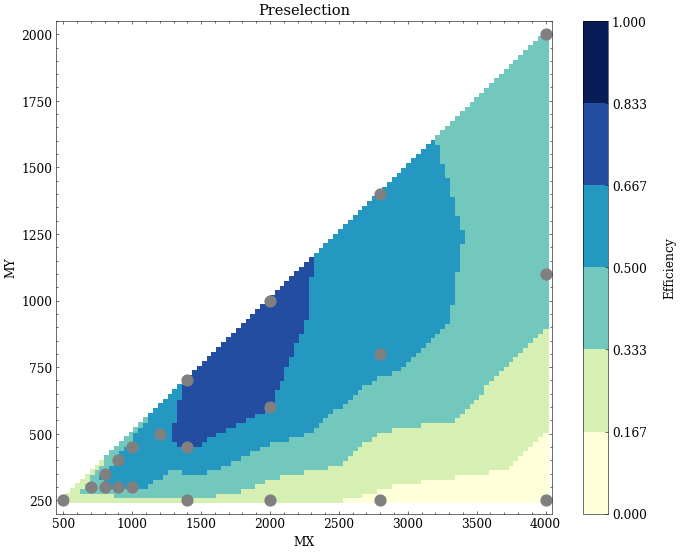

In [69]:
fig, axs = study.get_figax(size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
graph2d_array(mx, my, presel_eff, figax=(fig, axs), title=f'Preselection', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
graph_array(mx, my, figax=(fig, axs), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [179]:
gen_presel_eff = {
    n:signal.apply(lambda t,n=n : gen_matched_preselection(t,n)/t.total_events, report=True).npy
    for n in (1,2,3,4,5,6,7,8)
}

100%|██████████| 21/21 [00:00<00:00, 42.04it/s]


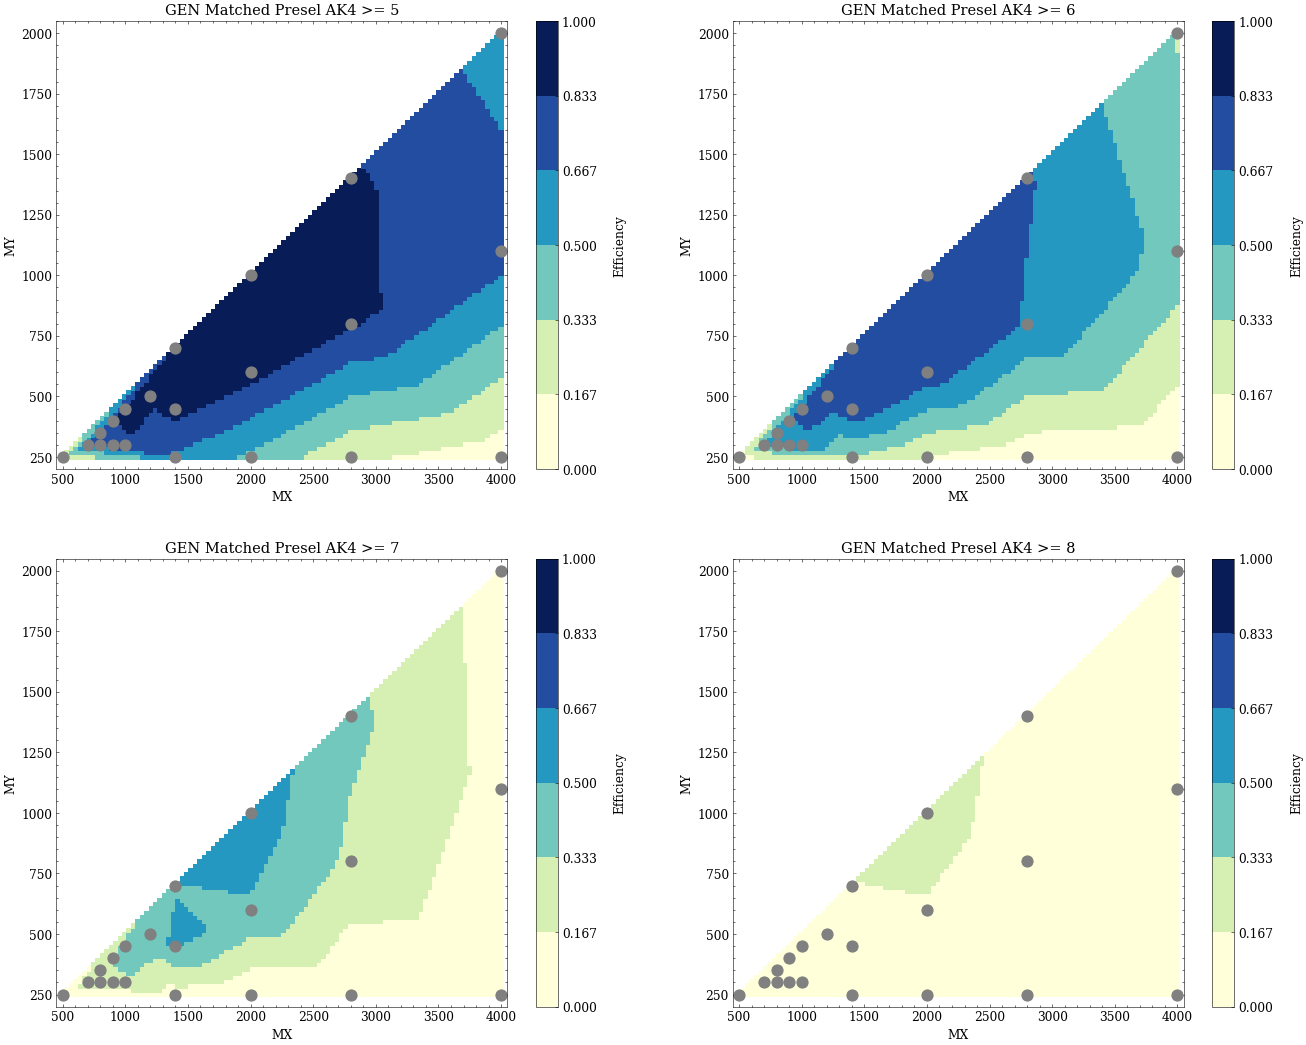

In [259]:
fig, axs = study.get_figax(4, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
# zlim=np.logspace(-2,0,7)
# zlim=(0,0.333,0.667,1.0)

for i, n in enumerate( (5,6,7,8) ):
    eff = gen_presel_eff[n]
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'GEN Matched Presel AK4 >= {n}', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [256]:
gen_all_eff = {
    n:signal.apply(lambda t,n=n : gen_matched_all(t,n)/t.total_events, report=True).npy
    for n in (1,2,3,4,5,6,7,8)
}

100%|██████████| 21/21 [00:00<00:00, 84.18it/s] 


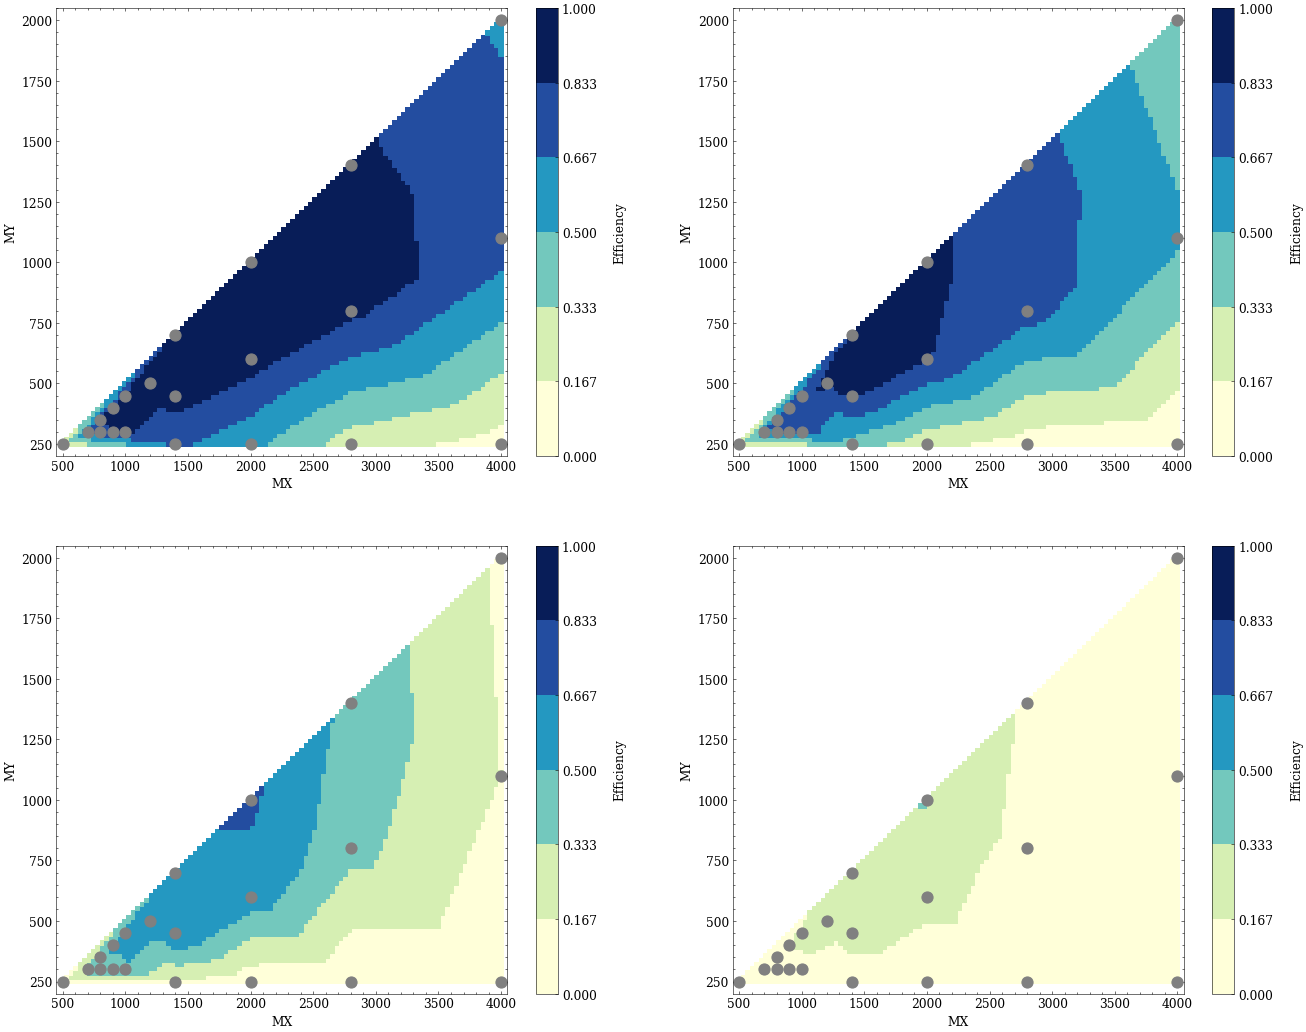

In [260]:
fig, axs = study.get_figax(4, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
# zlim=np.logspace(-2,0,7)
# zlim=(0,0.333,0.667,1.0)

for i, n in enumerate( (5,6,7,8) ):
    eff = gen_all_eff[n]

    mxmy_phase(
        signal,
        eff,
        zlim=zlim,
        g_cmap='YlGnBu',
        figax=(fig, axs.flat[i]),
        **kwargs,
    )


In [11]:
def n_presel_fatjet(t):
    fatjet_mask = t.fatjet_pt > 250
    fatjet_mask = fatjet_mask & (abs(t.fatjet_eta) < 2.5)
    # fatjet_mask = fatjet_mask & (abs(t.fatjet_m-125) < 50)

    t.extend(
        n_presel_fatjet=ak.sum(fatjet_mask, axis=1)
    )
signal.apply(n_presel_fatjet, report=True)

100%|██████████| 21/21 [00:57<00:00,  2.74s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [15]:
n_fatjet_eff = [
    signal.apply(lambda t,nfat=nfat : np.sum(t.n_presel_fatjet >= nfat)/t.total_events).npy
    for nfat in (1,2,3,4)
]

In [16]:
selected_signal = signal[::5]

100%|██████████| 4/4 [00:14<00:00,  3.52s/it]


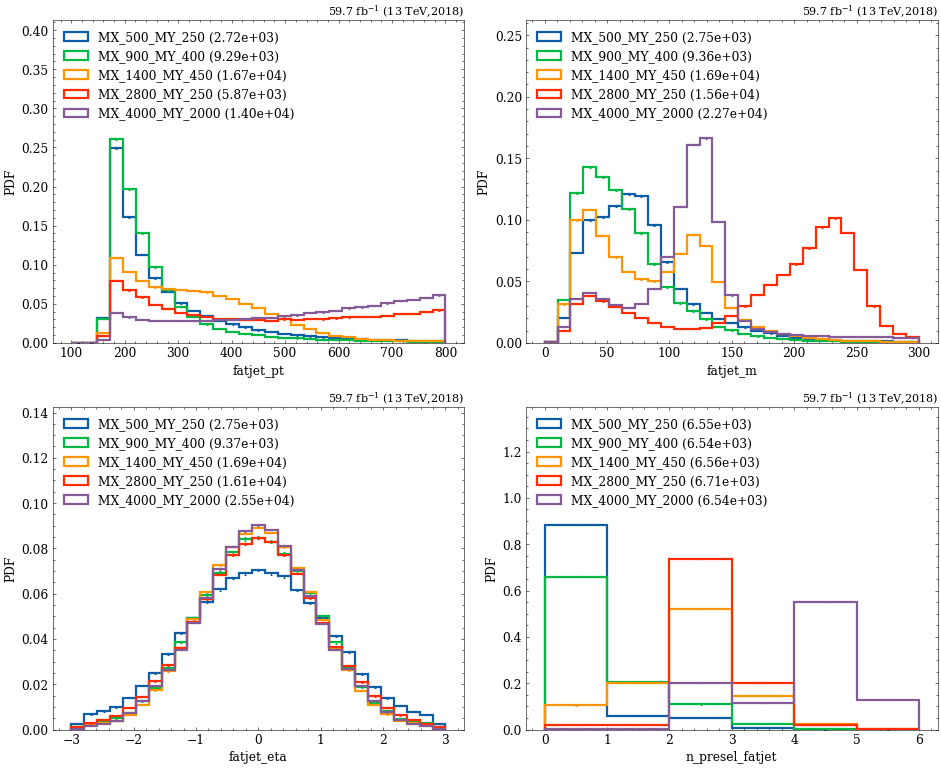

In [17]:
study.quick(
    selected_signal,
    legend=True,
    varlist=['fatjet_pt','fatjet_m','fatjet_eta','n_presel_fatjet'],
    binlist=[(100,800,30),(0,300,30),(-3,3,30)],
    efficiency=True,
)

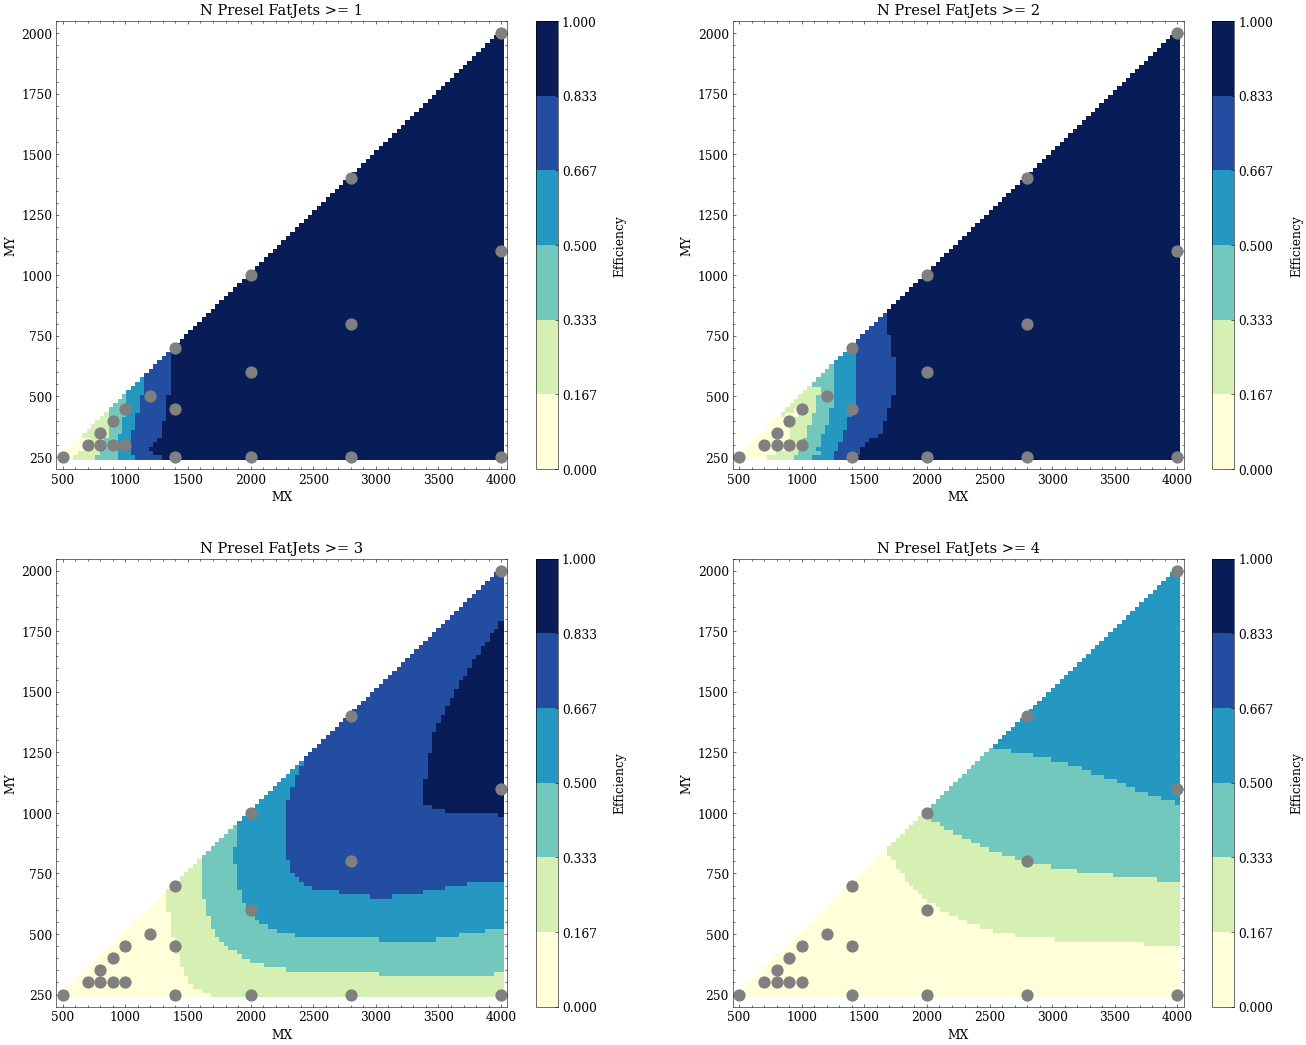

In [59]:


fig, axs = study.get_figax(4, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
for i, eff in enumerate(n_fatjet_eff):
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'N Presel FatJets >= {i+1}', interp=dict(kind='clough'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), title=f'N Presel FatJets >= {i+1}', g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [20]:
def n_gen_matched_higgs_fatjet(t):
    b_fatjet_pt = ak_stack(ak.unzip(t[[ f'gen_{quark}_recofatjet_pt' for quark in eightb.quarklist ]]), axis=1)
    b_fatjet_eta = ak_stack(ak.unzip(t[[ f'gen_{quark}_recofatjet_eta' for quark in eightb.quarklist ]]), axis=1)
    b_fatjet_m = ak_stack(ak.unzip(t[[ f'gen_{quark}_recofatjet_m' for quark in eightb.quarklist ]]), axis=1)

    matched_fatjet_pt = b_fatjet_pt[ b_fatjet_pt > 0 ]
    matched_fatjet_eta = b_fatjet_eta[ b_fatjet_pt > 0 ]
    matched_fatjet_m = b_fatjet_m[ b_fatjet_pt > 0 ]

    n_matched_bs = ak.sum( (b_fatjet_pt == matched_fatjet_pt[:,None]) & (b_fatjet_eta == matched_fatjet_eta[:,None]) & (b_fatjet_m == matched_fatjet_m[:,None]), axis=2)

    b1_n_matched_bs = n_matched_bs[:,1::2]
    b1_fatjet_pt, b2_fatjet_pt = b_fatjet_pt[:,::2],  b_fatjet_pt[:,1::2]
    b1_fatjet_eta, b2_fatjet_eta = b_fatjet_eta[:,::2],  b_fatjet_eta[:,1::2]
    b1_fatjet_m, b2_fatjet_m = b_fatjet_m[:,::2],  b_fatjet_m[:,1::2]

    higgs_matched = (b1_fatjet_pt == b2_fatjet_pt) & (b1_fatjet_eta == b2_fatjet_eta) & (b1_fatjet_m == b2_fatjet_m)

    higgs_fatjet_pt = ak.where( higgs_matched, b1_fatjet_pt, -999)
    higgs_fatjet_eta = ak.where( higgs_matched, b1_fatjet_eta, -999)
    higgs_fatjet_m = ak.where( higgs_matched, b1_fatjet_m, -999)
    higgs_fatjet_nbs = b1_n_matched_bs

    h1_fatjet_nbs = b1_n_matched_bs[:,1::2]
    h1_fatjet_pt, h2_fatjet_pt = higgs_fatjet_pt[:,::2], higgs_fatjet_pt[:,1::2]
    h1_fatjet_eta, h2_fatjet_eta = higgs_fatjet_eta[:,::2], higgs_fatjet_eta[:,1::2]
    h1_fatjet_m, h2_fatjet_m = higgs_fatjet_m[:,::2], higgs_fatjet_m[:,1::2]

    y_matched = (h1_fatjet_pt == h2_fatjet_pt) & (h1_fatjet_eta == h2_fatjet_eta) & (h1_fatjet_m == h2_fatjet_m)

    y_fatjet_pt = ak.where( y_matched, h1_fatjet_pt, -999)
    y_fatjet_eta = ak.where( y_matched, h1_fatjet_eta, -999)
    y_fatjet_m = ak.where( y_matched, h1_fatjet_m, -999)
    y_fatjet_nbs = h1_fatjet_nbs
    
    y1_fatjet_nbs = h1_fatjet_nbs[:,0]
    y1_fatjet_pt, y2_fatjet_pt = y_fatjet_pt[:,0], y_fatjet_pt[:,1]
    y1_fatjet_eta, y2_fatjet_eta = y_fatjet_eta[:,0], y_fatjet_eta[:,1]
    y1_fatjet_m, y2_fatjet_m =y_fatjet_m[:,0], y_fatjet_m[:,1]

    x_matched = (y1_fatjet_pt == y2_fatjet_pt) & (y1_fatjet_eta == y2_fatjet_eta) & (y1_fatjet_m == y2_fatjet_m)

    x_fatjet_pt = ak.where( x_matched, y1_fatjet_pt, -999)
    x_fatjet_eta = ak.where( x_matched, y1_fatjet_eta, -999)
    x_fatjet_m = ak.where( x_matched, y1_fatjet_m, -999)
    x_fatjet_nbs = y1_fatjet_nbs


    presel_higgs_matched = ( higgs_fatjet_pt > 250 ) & ( abs(higgs_fatjet_eta) < 2.5 )
    presel_y_matched = ( y_fatjet_pt > 250 ) & ( abs(y_fatjet_eta) < 2.5 )
    presel_x_matched = ( x_fatjet_pt > 250 ) & ( abs(x_fatjet_eta) < 2.5 )

    t.extend(
        n_gen_matched_higgs_presel_fatjet=ak.sum(presel_higgs_matched, axis=1),
        higgs_fatjet_pt=higgs_fatjet_pt,
        higgs_fatjet_eta=higgs_fatjet_eta,
        higgs_fatjet_m=higgs_fatjet_m,
        higgs_fatjet_nbs=higgs_fatjet_nbs,
        higgs_fatjet_presel=presel_higgs_matched,
        
        n_gen_matched_y_presel_fatjet=ak.sum(presel_y_matched, axis=1),
        y_fatjet_pt=y_fatjet_pt,
        y_fatjet_eta=y_fatjet_eta,
        y_fatjet_m=y_fatjet_m,
        y_fatjet_nbs=y_fatjet_nbs,
        y_fatjet_presel=presel_y_matched,
        
        x_fatjet_pt=x_fatjet_pt,
        x_fatjet_eta=x_fatjet_eta,
        x_fatjet_m=x_fatjet_m,
        x_fatjet_nbs=x_fatjet_nbs,
        x_fatjet_presel=presel_x_matched,
    )

signal.apply(n_gen_matched_higgs_fatjet, report=True)

100%|██████████| 21/21 [01:20<00:00,  3.84s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


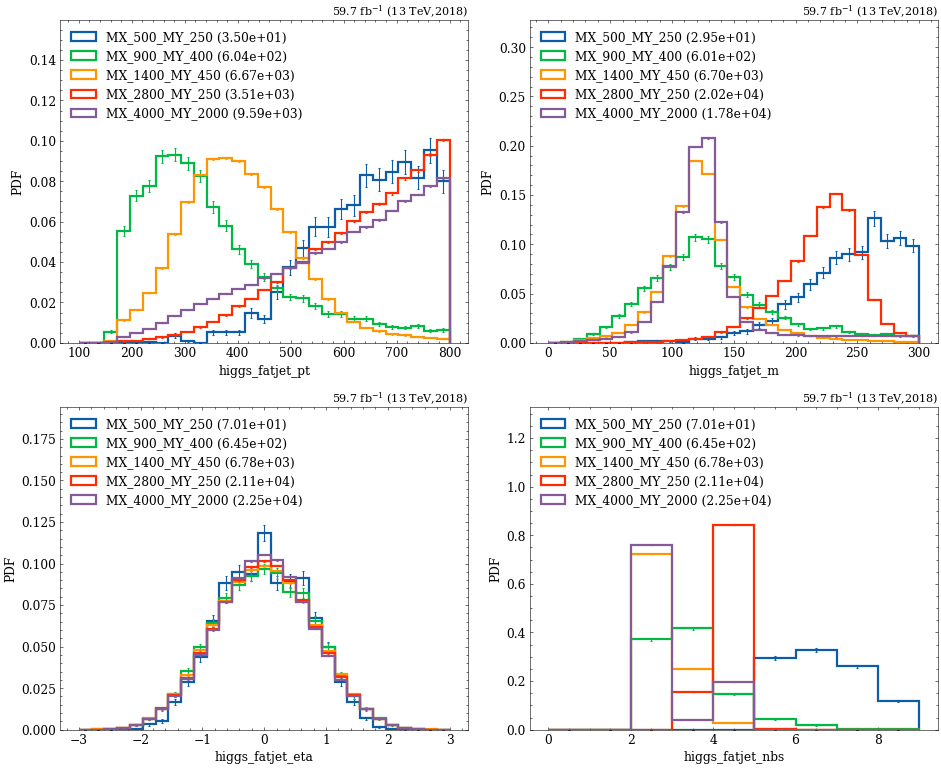

In [21]:
study.quick(
    selected_signal,
    indices=lambda t: t.higgs_fatjet_pt > 0,
    legend=True,
    varlist=['higgs_fatjet_pt','higgs_fatjet_m','higgs_fatjet_eta','higgs_fatjet_nbs'],
    binlist=[(100,800,30),(0,300,30),(-3,3,30)],
    efficiency=True,
)

In [22]:
n_gen_matched_higgs_presel_fatjet = [
    signal.apply(lambda t,nfat=nfat : np.sum(t.n_gen_matched_higgs_presel_fatjet >= nfat)/t.total_events).npy
    for nfat in (1,2,3,4)
]

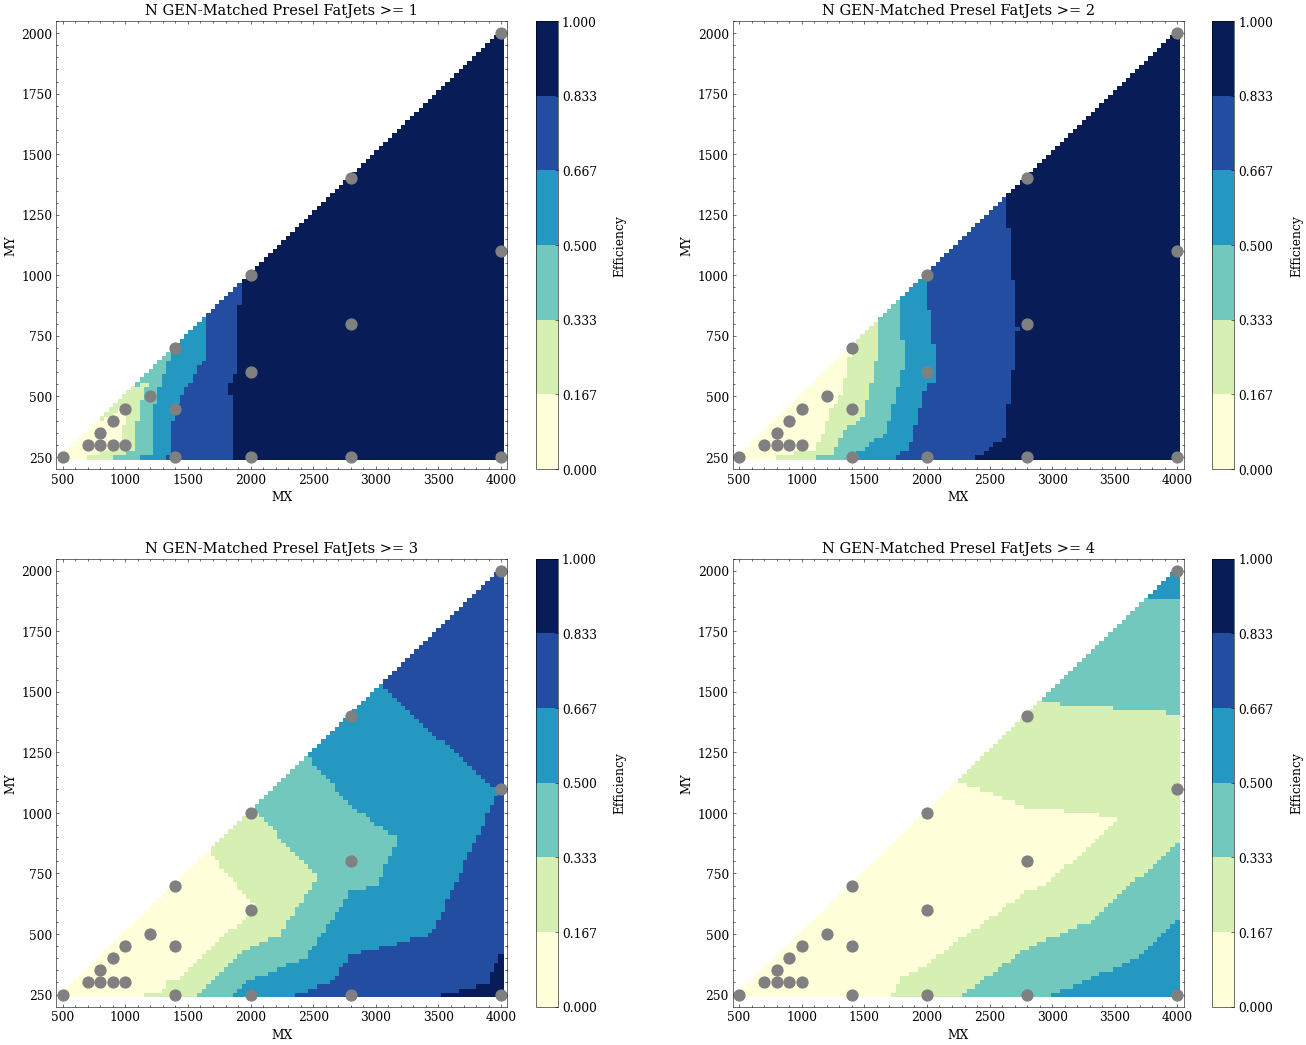

In [60]:
fig, axs = study.get_figax(4, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
for i, eff in enumerate(n_gen_matched_higgs_presel_fatjet):
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'N GEN-Matched Presel FatJets >= {i+1}', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


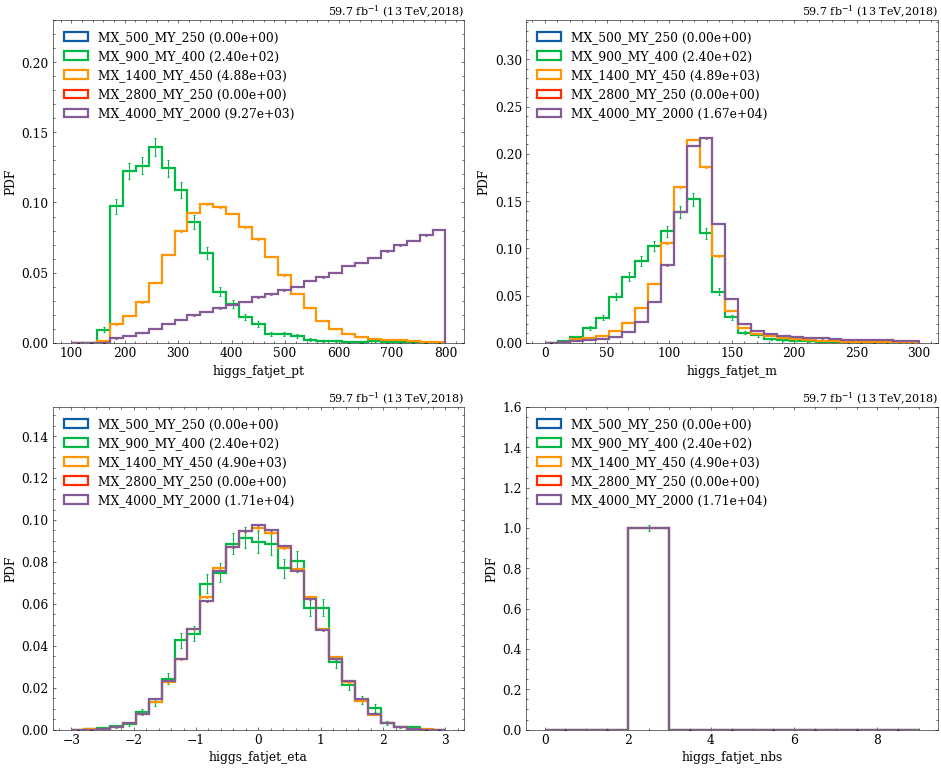

In [24]:
study.quick(
    selected_signal,
    indices=lambda t: (t.higgs_fatjet_pt > 0) & (t.higgs_fatjet_nbs == 2),
    legend=True,
    varlist=['higgs_fatjet_pt','higgs_fatjet_m','higgs_fatjet_eta','higgs_fatjet_nbs'],
    binlist=[(100,800,30),(0,300,30),(-3,3,30), np.arange(10)],
    efficiency=True,
)

In [25]:
n_gen_matched_higgs_presel_fatjet_2bs = [
    signal.apply(lambda t,nfat=nfat : np.sum(ak.sum( t.higgs_fatjet_presel & (t.higgs_fatjet_nbs == 2), axis=1 ) >= nfat)/t.total_events).npy
    for nfat in (1,2,3,4)
]

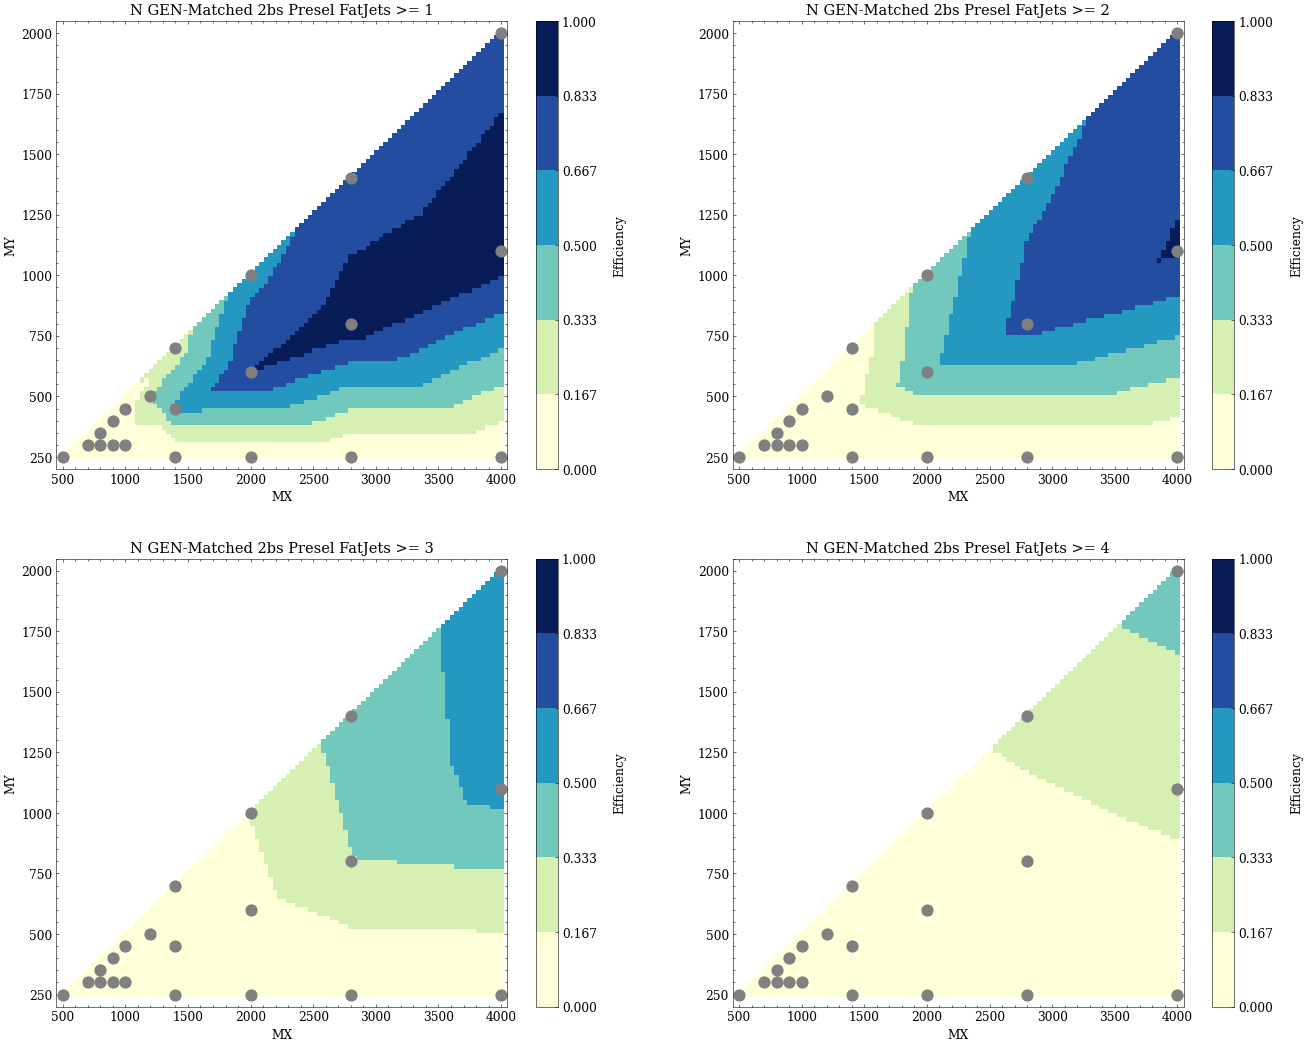

In [61]:

fig, axs = study.get_figax(4, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
for i, eff in enumerate(n_gen_matched_higgs_presel_fatjet_2bs):
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'N GEN-Matched 2bs Presel FatJets >= {i+1}', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


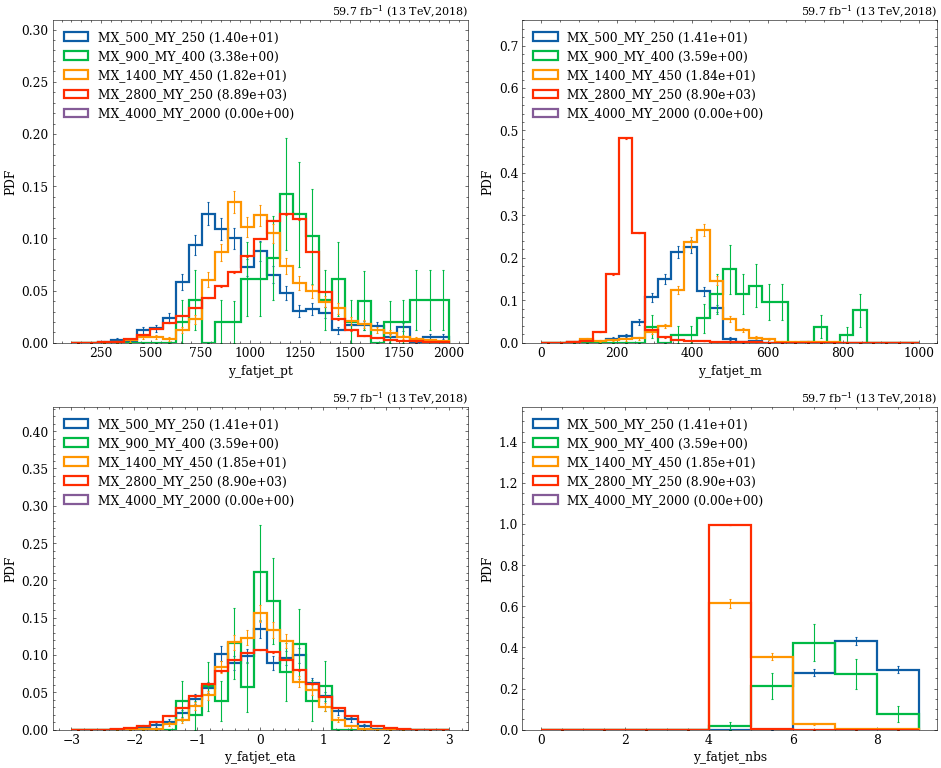

In [27]:
study.quick(
    selected_signal,
    indices=lambda t: (t.y_fatjet_pt > 0),
    legend=True,
    varlist=['y_fatjet_pt','y_fatjet_m','y_fatjet_eta','y_fatjet_nbs'],
    binlist=[(100,2000,30),(0,1000,30),(-3,3,30), np.arange(10)],
    efficiency=True,
)

In [28]:
n_gen_matched_y_presel_fatjet = [
    signal.apply(lambda t,nfat=nfat : np.sum(t.n_gen_matched_y_presel_fatjet >= nfat)/t.total_events).npy
    for nfat in (1,2,)
]

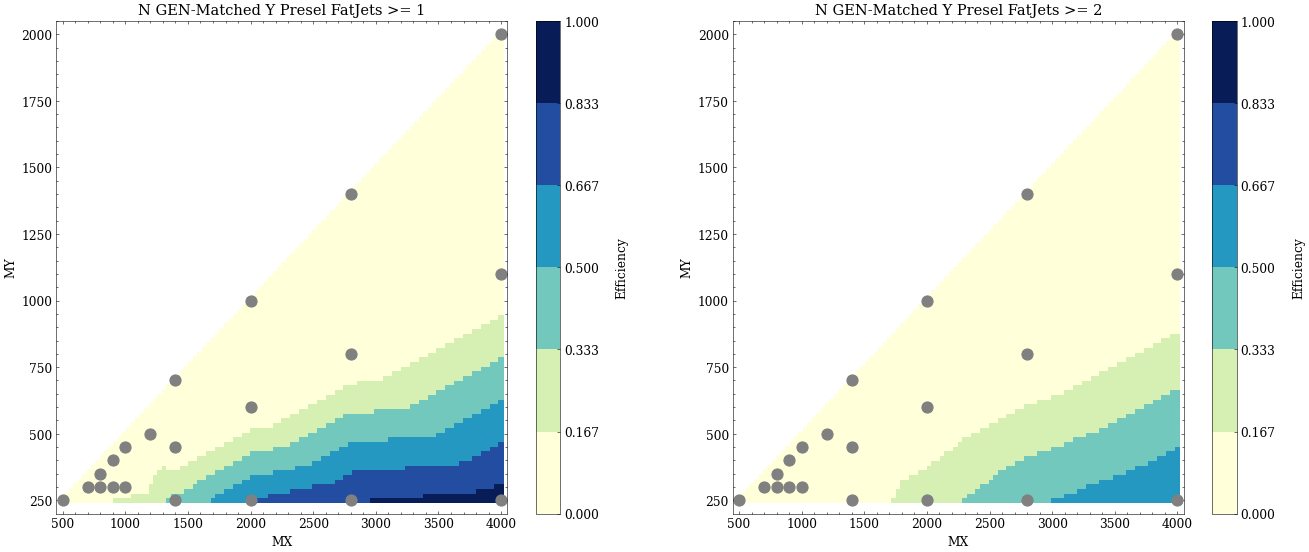

In [62]:
fig, axs = study.get_figax(2, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.linspace(0,1,7)
for i, eff in enumerate(n_gen_matched_y_presel_fatjet):
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'N GEN-Matched Y Presel FatJets >= {i+1}', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [30]:
n_gen_matched_y_presel_fatjet_4bs = [
    signal.apply(lambda t,nfat=nfat : np.sum(ak.sum( t.y_fatjet_presel & (t.y_fatjet_nbs == 4), axis=1 ) >= nfat)/t.total_events).npy
    for nfat in (1,2,)
]

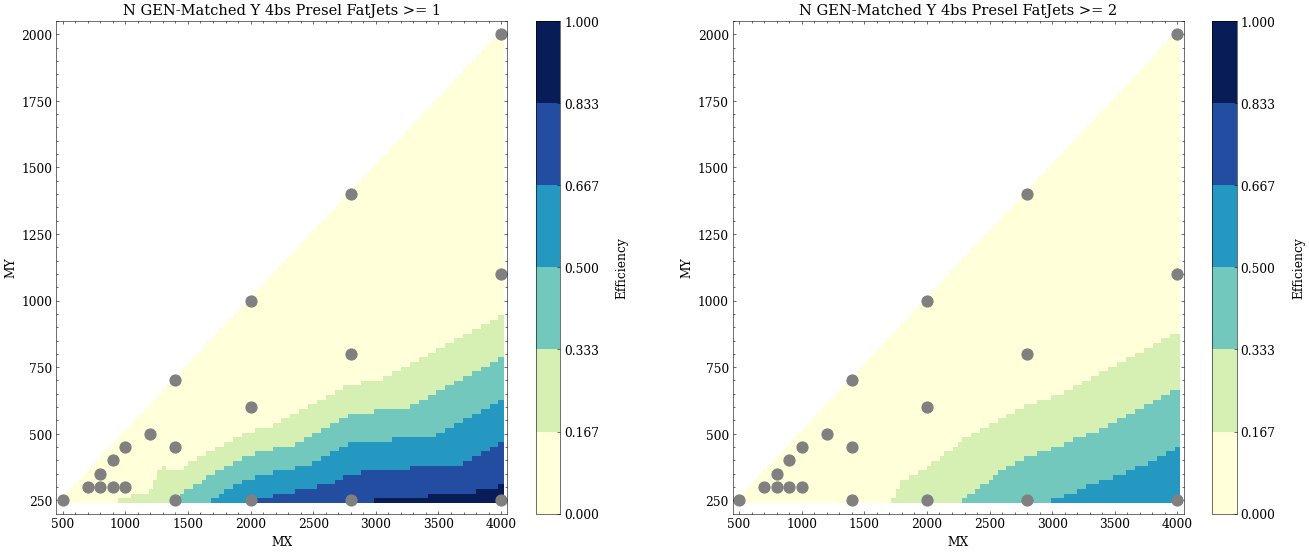

In [63]:
fig, axs = study.get_figax(2, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

zlim=(0,1)
zlim=np.linspace(0,1,7)
for i, eff in enumerate(n_gen_matched_y_presel_fatjet_4bs):
    graph2d_array(mx, my, eff, figax=(fig, axs.flat[i]), title=f'N GEN-Matched Y 4bs Presel FatJets >= {i+1}', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
    graph_array(mx, my, figax=(fig, axs.flat[i]), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


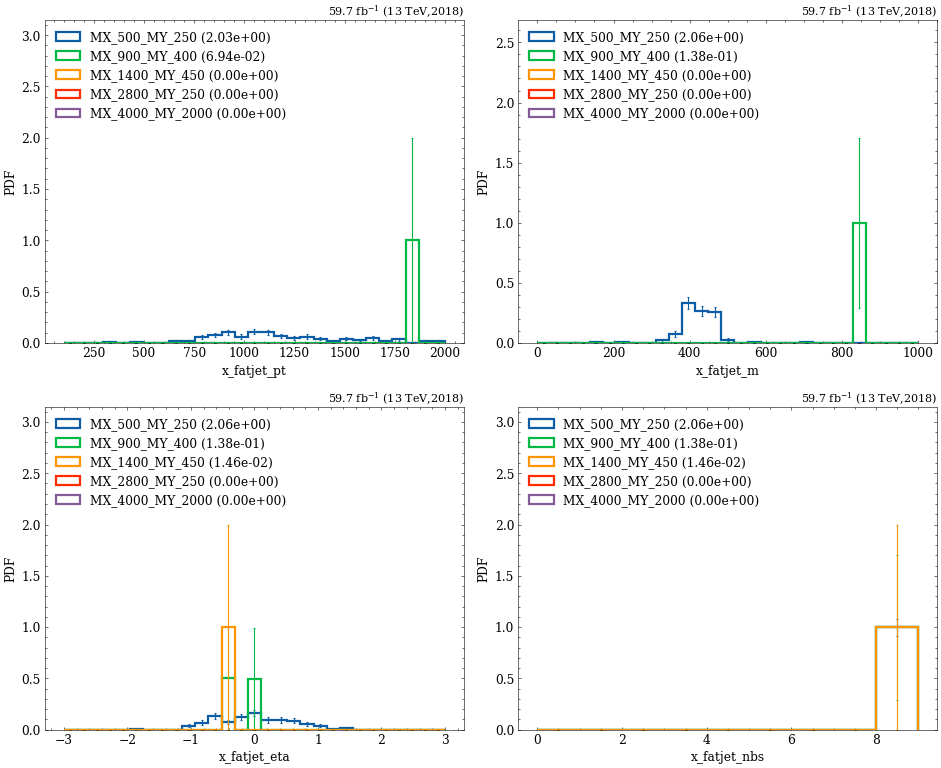

In [41]:
study.quick(
    selected_signal,
    masks=lambda t: (t.x_fatjet_pt > 0),
    legend=True,
    varlist=['x_fatjet_pt','x_fatjet_m','x_fatjet_eta','x_fatjet_nbs'],
    binlist=[(100,2000,30),(0,1000,30),(-3,3,30), np.arange(10)],
    efficiency=True,
)

In [43]:
gen_presel_x_fatjet = signal.apply(lambda t : np.sum(t.x_fatjet_presel == 1)/t.total_events).npy

 62%|██████▏   | 13/21 [10:09<06:15, 46.92s/it]


(<Figure size 800x640 with 2 Axes>,
 <AxesSubplot:title={'center':'GEN-Matched X 8bs Presel FatJet'}, xlabel='MX', ylabel='MY'>)

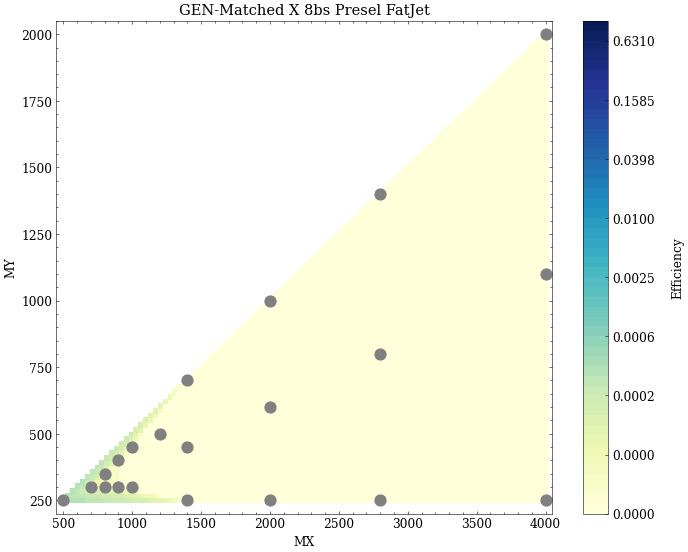

In [49]:
fig, axs = study.get_figax(1, size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel='Efficiency', 
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)

zlim=(0,1)
zlim=np.logspace(-5,0,51)

graph2d_array(mx, my, gen_presel_x_fatjet, figax=(fig, axs), title=f'GEN-Matched X 8bs Presel FatJet', interp=dict(kind='linear'), colorbar=True, g_cmap='YlGnBu', zlim=zlim, **kwargs)
graph_array(mx, my, figax=(fig, axs), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [156]:
boosted_h_eff = Graph2D(mx, my, n_gen_matched_higgs_presel_fatjet_2bs[0], cmap='YlGnBu',).smooth('linear')
boosted_y_eff = Graph2D(mx, my, n_gen_matched_y_presel_fatjet_4bs[0], cmap='YlOrRd').smooth('linear')

In [173]:
eff_cutoff = 0.3

boosted_h_mask = (boosted_h_eff.z_array > eff_cutoff) & (boosted_h_eff.z_array > boosted_y_eff.z_array)
boosted_y_mask = (boosted_y_eff.z_array > eff_cutoff) & (boosted_h_eff.z_array < boosted_y_eff.z_array)



boosted_h_sig = Graph2D(
    boosted_h_eff.x_array[boosted_h_mask],
    boosted_h_eff.y_array[boosted_h_mask],
    boosted_h_eff.z_array[boosted_h_mask],
    **boosted_h_eff.kwargs,
)
boosted_y_sig = Graph2D(
    boosted_y_eff.x_array[boosted_y_mask],
    boosted_y_eff.y_array[boosted_y_mask],
    boosted_y_eff.z_array[boosted_y_mask],
    **boosted_y_eff.kwargs,
)


(<Figure size 800x640 with 3 Axes>, <AxesSubplot:xlabel='MX', ylabel='MY'>)

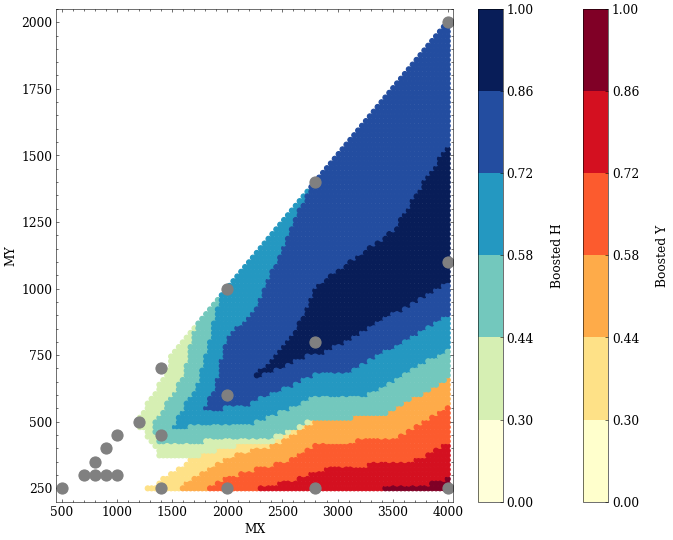

In [174]:
fig, axs = study.get_figax(1, size=(10,8))


kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    xlim=(450,4050),
    ylim=(200,2050),
    # logy=True, logx=True, 
)
zlim=[0]+np.linspace(eff_cutoff,1,6).tolist()
# zlim=(0,0.7,1.0)

plot_graph2d(boosted_y_sig, figax=(fig,axs), zlim=zlim, colorbar=True, zlabel='Boosted Y', size=20, **kwargs)
plot_graph2d(boosted_h_sig, figax=(fig,axs), zlim=zlim, colorbar=True, zlabel='Boosted H', size=20, **kwargs)

graph_array(mx, my, figax=(fig, axs), g_color='grey', g_ls='none', g_markersize=10, **kwargs)